In [1]:
import clip
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from segment_anything import sam_model_registry, SamPredictor

# Init CLIP and data

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _ = clip.load("ViT-B/16", device=device)
model.eval()
preprocess =  Compose([Resize((224, 224), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

In [3]:
pil_img = Image.open("demo.jpg")
cv2_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)
all_texts = ['airplane', 'bag', 'bed', 'bedclothes', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'building', 'bus', 'cabinet', 'car', 'cat', 'ceiling', 'chair', 'cloth', 'computer', 'cow', 'cup', 'curtain', 'dog', 'door', 'fence', 'floor', 'flower', 'food', 'grass', 'ground', 'horse', 'keyboard', 'light', 'motorbike', 'mountain', 'mouse', 'person', 'plate', 'platform', 'potted plant', 'road', 'rock', 'sheep', 'shelves', 'sidewalk', 'sign', 'sky', 'snow', 'sofa', 'table', 'track', 'train', 'tree', 'truck', 'tv monitor', 'wall', 'water', 'window', 'wood']
target_texts = ['bench', 'person', 'ground', 'building']

# Explain raw predictions of CLIP, which are opposite and noisy.

CLIP: bench


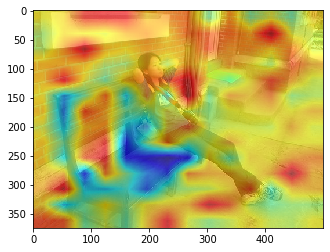

CLIP: building


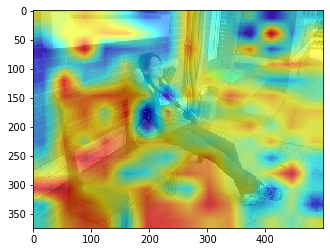

CLIP: ground


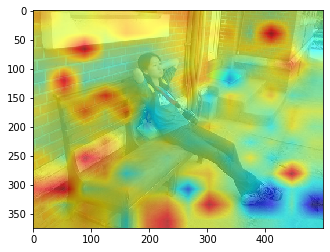

CLIP: person


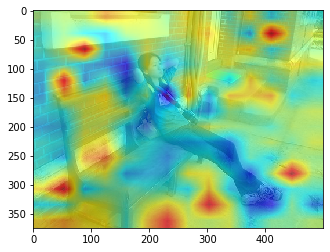

In [4]:
with torch.no_grad():
    # Extract image features
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Similarity map from image tokens with min-max norm and resize, B,H,W,N
    features = image_features @ text_features.t()
    similarity_map = clip.get_similarity_map(features[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP:', all_texts[n])
            plt.imshow(vis)
            plt.show()

# Explain CLIP via our CLIP Surgery

In [5]:
model, preprocess = clip.load("CS-ViT-B/16", device=device)
model.eval()

CLIPSurgery(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
   

CLIP Surgery: bench


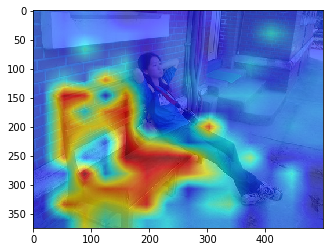

CLIP Surgery: building


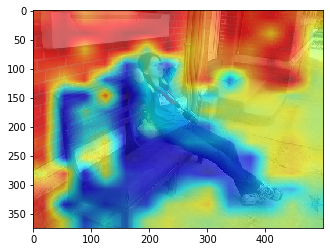

CLIP Surgery: ground


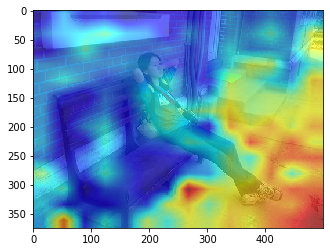

CLIP Surgery: person


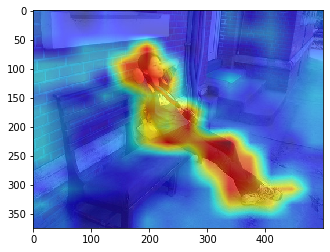

In [6]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery:', all_texts[n])
            plt.imshow(vis)
            plt.show()

# CLIP Surgery using higher resolution

This preprocess for all next cases

In [7]:
preprocess =  Compose([Resize((512, 512), interpolation=BICUBIC), ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])
image = preprocess(pil_img).unsqueeze(0).to(device)

CLIP Surgery 512: bench


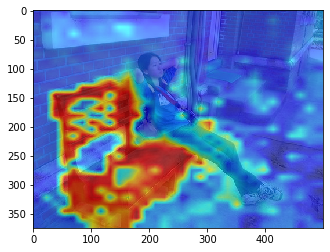

CLIP Surgery 512: building


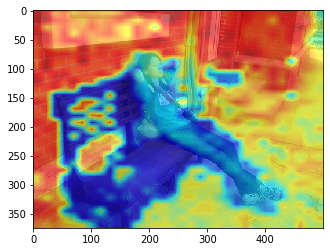

CLIP Surgery 512: ground


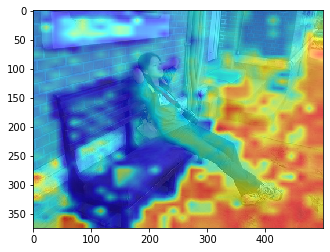

CLIP Surgery 512: person


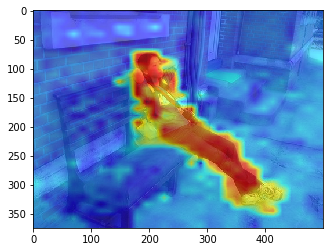

In [8]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            if all_texts[n] not in target_texts:
                continue
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery 512:', all_texts[n])
            plt.imshow(vis)
            plt.show()

# CLIP Surgery for a single text, without fixed label sets

In [9]:
texts = ['shoes']

CLIP Surgery for a single text: shoes


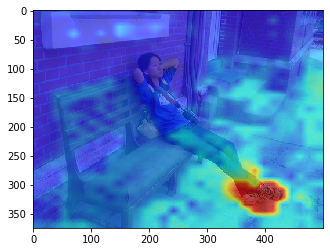

In [10]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, texts, device)

    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # Apply feature surgery for single text
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            print('CLIP Surgery for a single text:', texts[n])
            plt.imshow(vis)
            plt.show()

# Text to points from CLIP Surgery to guide SAM

Init SAM

In [11]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(np.array(pil_img))

Inference CLIP Surgery and SAM

SAM guided by points from CLIP Surgery: bench


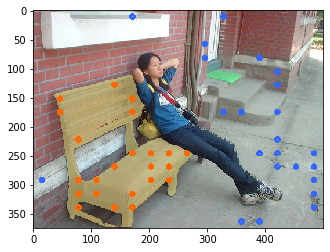

SAM guided by points from CLIP Surgery: building


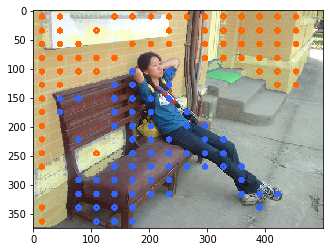

SAM guided by points from CLIP Surgery: ground


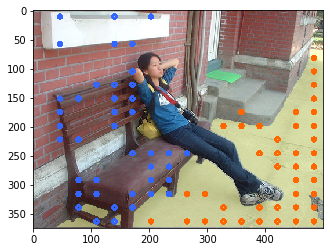

SAM guided by points from CLIP Surgery: person


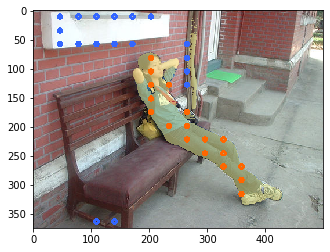

Sometimes, the points are accurate, while the masks from SAM still need improvements.
I mean, some failure cases are not caused by wrong points.


In [12]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image) # Image resized to 512
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, all_texts, device)

    # Apply feature surgery, no batch
    similarity = clip.clip_feature_surgery(image_features, text_features)[0]

    # Inference SAM with points from CLIP Surgery
    for n in range(similarity.shape[-1]):
        if all_texts[n] not in target_texts:
            continue
        points, labels = clip.similarity_map_to_points(similarity[1:, n], cv2_img.shape[:2], t=0.8)
        masks, scores, logits = predictor.predict(point_labels=labels, point_coords=np.array(points), multimask_output=True)
        mask = masks[np.argmax(scores)]
        mask = mask.astype('uint8')

        # Visualize the results
        vis = cv2_img.copy()
        vis[mask > 0] = vis[mask > 0] // 2 + np.array([153, 255, 255], dtype=np.uint8) // 2
        for i, [x, y] in enumerate(points):
            cv2.circle(vis, (x, y), 3, (0, 102, 255) if labels[i] == 1 else (255, 102, 51), 3)
        vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
        print('SAM guided by points from CLIP Surgery:', all_texts[n])
        plt.imshow(vis)
        plt.show()
    print('Sometimes, the points are accurate, while the masks from SAM still need improvements.')
    print('I mean, some failure cases are not caused by wrong points.')

# Inference CLIP Surgery and SAM for a single text

In [13]:
texts = ['bench']

SAM & CLIP Surgery for single text: bench


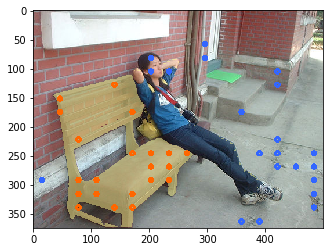

In [14]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, texts, device)

    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # CLIP feature surgery with costum redundant features
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)[0]
    
    # Inference SAM with points from CLIP Surgery
    points, labels = clip.similarity_map_to_points(similarity[1:, 0], cv2_img.shape[:2], t=0.8)
    masks, scores, logits = predictor.predict(point_labels=labels, point_coords=np.array(points), multimask_output=True)
    mask = masks[np.argmax(scores)]
    mask = mask.astype('uint8')

    # Visualize the results
    vis = cv2_img.copy()
    vis[mask > 0] = vis[mask > 0] // 2 + np.array([153, 255, 255], dtype=np.uint8) // 2
    for i, [x, y] in enumerate(points):
        cv2.circle(vis, (x, y), 3, (0, 102, 255) if labels[i] == 1 else (255, 102, 51), 3)
    vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
    print('SAM & CLIP Surgery for single text:', texts[0])
    plt.imshow(vis)
    plt.show()

# CLIP Surgery + SAM for combined targets

We use "+" to combine texts, instead of a whole sentence (obvious text may take the lead thus overlook rest)

In [15]:
text = 'person+bench'

SAM & CLIP Surgery for texts combination: person+bench


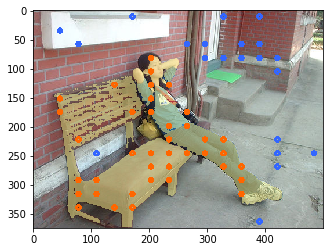

In [16]:
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, text.split('+'), device)
    
    # Combine features after removing redundant features and min-max norm
    sm = clip.clip_feature_surgery(image_features, text_features, redundant_features)[0, 1:, :]
    sm_norm = (sm - sm.min(0, keepdim=True)[0]) / (sm.max(0, keepdim=True)[0] - sm.min(0, keepdim=True)[0])
    sm_mean = sm_norm.mean(-1, keepdim=True)

    # get positive points from individual maps, and negative points from the mean map
    p, l = clip.similarity_map_to_points(sm_mean, cv2_img.shape[:2], t=0.8)
    num = len(p) // 2
    points = p[num:] # negatives in the second half
    labels = [l[num:]]
    for i in range(sm.shape[-1]):
        p, l = clip.similarity_map_to_points(sm[:, i], cv2_img.shape[:2], t=0.8)
        num = len(p) // 2
        points = points + p[:num] # positive in first half
        labels.append(l[:num])
    labels = np.concatenate(labels, 0)

    # Inference SAM with points from CLIP Surgery
    masks, scores, logits = predictor.predict(point_labels=labels, point_coords=np.array(points), multimask_output=True)
    mask = masks[np.argmax(scores)]
    mask = mask.astype('uint8')

    # Visualize the results
    vis = cv2_img.copy()
    vis[mask > 0] = vis[mask > 0] // 2 + np.array([153, 255, 255], dtype=np.uint8) // 2
    for i, [x, y] in enumerate(points):
        cv2.circle(vis, (x, y), 3, (0, 102, 255) if labels[i] == 1 else (255, 102, 51), 3)
    vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
    print('SAM & CLIP Surgery for texts combination:', text)
    plt.imshow(vis)
    plt.show()